In [1]:
# conda create --name bcitoolbox python=3.10

from bcitoolbox_local import simulateVV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from collections import defaultdict
import statsmodels.api as sm
from scipy.stats import  mannwhitneyu

plot_indiv = False

In [2]:
strategy_map = {
    'Averaging': 'ave',
    'Selection': 'sel',
    'Matching': 'mat',
}

model_map = {
    'bci': 'Bayesian Causal Inference',
    'ff':  'Forced Fusion',
    'fs': 'Full Segregation',
    'mle': 'Maximum Likelihood Estimation'
}


def simulate_data(parameters, strategy_name, fitType, file_name,
                  modeling_data_path='csv/modeling/data/',
                  n_simulation=10000, biOnly=0):
    
    data_file_path = modeling_data_path + file_name
    behavior_data = np.loadtxt(data_file_path, delimiter=',')
    if len(behavior_data) < 10: return

    strategy = strategy_map.get(strategy_name[0])

    error, modelprop, dataprop, responsesSim, r2 = simulateVV(parameters, 
                                                              n_simulation, 
                                                              behavior_data, 
                                                              biOnly,
                                                              strategy, 
                                                              fitType,)

    return error, modelprop, dataprop, responsesSim, r2

def get_subject_ids():
    # Get unique subject IDs
    subject_ids = set()
    for filename in os.listdir('csv/modeling/data/'):
        if filename.startswith('LV') or filename.startswith('SV'):
            parts = filename.split('_')     
            subject_ids.add(parts[0])
            
    return sorted(list(subject_ids))

def get_best_models(model, loc_order=None):
    df = pd.read_csv(f'csv/modeling/outputs/{model}_best_models.csv')
    df['group'] = df['subject_id'].apply(lambda x: 'Low Vision' if str(x).startswith('LV') else 'Control')

    if loc_order is None: loc_order = ['raw', 'visible', 'invisible', '5', '10', '15']
    df['location'] = pd.Categorical(df['location'], categories=loc_order, ordered=True)
    df_means = df.groupby(['location', 'group'], observed=True)[['bic', 'r2']].agg(['mean', 'sem']).round(2)
    df_means = df_means.reindex(loc_order, level='location')
    return df, df_means


def find_best_model_per_subject():
    
    bci_models, _ = get_best_models('bci')
    ff_models, _ = get_best_models('ff')
    fs_models, _ = get_best_models('fs')
    mle_models, _ = get_best_models('mle')

    bci_models['model'] = 'bci'
    ff_models['model'] = 'ff'
    fs_models['model'] = 'fs'
    mle_models['model'] = 'mle'

    all_models = pd.concat([bci_models, ff_models, fs_models, mle_models], ignore_index=True)

    idx_of_best_models = all_models.groupby(['subject_id', 'location'], observed=True)['bic'].idxmin()

    best_models_df = all_models.loc[idx_of_best_models]

    loc_order = ['raw', 'visible', 'invisible', '5', '10', '15']
    best_models_df['location'] = pd.Categorical(
        best_models_df['location'], categories=loc_order, ordered=True
    )
    best_models_df = best_models_df.sort_values(
        ['subject_id', 'location']
    ).reset_index(drop=True)
    best_models_df.to_csv('csv/modeling/outputs/best_model_per_subject.csv', index=False)

    return best_models_df


In [3]:
# Simulate data for each subject
condition_map = None
# best_models_df, _ = get_best_models('bci')
best_models_df = find_best_model_per_subject()
all_props = defaultdict(dict)

for location in ['raw']: #['visible', 'invisible']:
    location_df = best_models_df[best_models_df['location'] == location]

    for index, row in location_df.iterrows():
        subject = row['subject_id']
        file_name = f"{subject}_{location}.csv"
        Strategies = [row['strategy']]
        FitType = row['fit_type']
        model = row['model']

        if condition_map is None:
            behavior_data = np.loadtxt(f'csv/modeling/data/{file_name}', delimiter=',')
            stimuli = behavior_data[:, [0, 1]]
            condition_map = np.unique(stimuli, axis=0)
            print("condition_map.shape:", condition_map.shape)

        print("\n=======================================")
        print(f"Simulating data for {subject} at {location}")
        print("=======================================\n")

        parameters = [
            row['pcommon'],
            row['sigma_v'],
            row['sigma_a'],
            row['mu_p'],
            row['sigma_p'],            
        ]
        results = simulate_data(parameters, Strategies, FitType, file_name)

        if results is not None:
            error, modelprop, dataprop, responsesSim, r2 = results
            # store simulated data
            all_props[subject][location] = {
                'modelprop': modelprop,
                'dataprop': dataprop,
                'r2': r2
            }

            # Split modelprop and dataprop according to conditions
            for i, condition in enumerate(condition_map):
                all_props[subject][location][f'F{int(condition[0])}B{int(condition[1])}'] = {
                    'model': model,
                    'Visual model': modelprop[0, i, :],
                    'Visual response': dataprop[0, i, :],
                }

condition_map.shape: (4, 2)

Simulating data for LV001 at raw

fit type = mll
===== DEBUG: fixed values = [0.5, 0.4, 0.8, 4000, 2, 0, 0] =====
===== DEBUG: pcommon = 0.829698707 =====
===== DEBUG: sigma_v = 0.323588417 =====
===== DEBUG: sigma_a = 0.2 =====
===== DEBUG: sigma_p = 1.5 =====
===== DEBUG: mu_p = 0.814825675 =====
R2 on all
0.8086661294042171
Sum Loglike    Optimal
-659.2604374551305 -133.73873191329383
Explainable variance, r2:
0.7917211063102624

Simulating data for LV002 at raw

fit type = mll
===== DEBUG: fixed values = [0.5, 0.4, 0.8, 4000, 2, 0, 0] =====
===== DEBUG: pcommon = 1.0 =====
===== DEBUG: sigma_v = 0.606008652 =====
===== DEBUG: sigma_a = 0.2 =====
===== DEBUG: sigma_p = 1.5 =====
===== DEBUG: mu_p = 4000.0 =====
R2 on all
0.23621354944466313
Sum Loglike    Optimal
-2393.5815426098725 -120.93580930739274
Explainable variance, r2:
-0.11516683195498612

Simulating data for LV003 at raw

fit type = mll
===== DEBUG: fixed values = [0.5, 0.4, 0.8, 4000, 2, 0, 0

c:\Users\Ailene\Desktop\GitHub\doubleFlash-matlab\for_publication\Data\bcitoolbox_local\BCIbox.py:146: RuntimeWarning: invalid value encountered in divide
  PCDU = np.multiply(PDUC, pcommon) / (np.multiply(PDUC, pcommon) + np.multiply(PDUnC, 1 - pcommon))
c:\Users\Ailene\Desktop\GitHub\doubleFlash-matlab\for_publication\Data\bcitoolbox_local\BCIbox.py:259: RuntimeWarning: invalid value encountered in cast
  k1 = np.minimum(np.maximum(1, np.round(responsesSim[np.where(trialTypeSim==j),i]).astype(int)), N-1)


R2 on all
0.5422346499883726
Sum Loglike    Optimal
-909.9741624555706 -188.7762937993373
Explainable variance, r2:
0.40394619052066416

Simulating data for LV012 at raw

fit type = mll
===== DEBUG: fixed values = [0.5, 0.4, 0.8, 4000, 2, 0, 0] =====
===== DEBUG: pcommon = 1.0 =====
===== DEBUG: sigma_v = 0.394829416 =====
===== DEBUG: sigma_a = 0.2 =====
===== DEBUG: sigma_p = 1.5 =====
===== DEBUG: mu_p = 4000.0 =====
R2 on all
0.2261008051693557
Sum Loglike    Optimal
-2346.514694034696 -63.988472070776105
Explainable variance, r2:
-0.0821688993094376

Simulating data for LV013 at raw

fit type = mll
===== DEBUG: fixed values = [0.5, 0.4, 0.8, 4000, 2, 0, 0] =====
===== DEBUG: pcommon = 0.813381627 =====
===== DEBUG: sigma_v = 0.35510612 =====
===== DEBUG: sigma_a = 0.2 =====
===== DEBUG: sigma_p = 1.5 =====
===== DEBUG: mu_p = 1.243166226 =====
R2 on all
0.6664851503131196
Sum Loglike    Optimal
-904.3708211240034 -108.17933766074256
Explainable variance, r2:
0.6333189693702079

Si

<Figure size 640x480 with 0 Axes>

In [4]:
vis_col = '#6636a5'
resp_col = '#9b72cf'

subject_ids = get_subject_ids()
location = 'raw'
if plot_indiv:
    for subject_id in subject_ids:
        # start plotting
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(7, 2), sharey=True)
        flattened_axes = axes.flatten()
        ax=0

        for condition in ['F0B0', 'F1B0', 'F1B1', 'F1B2']:            
            flattened_axes[ax].plot(all_props[subject_id][location][condition]['Visual response'], resp_col, label='Visual response')
            flattened_axes[ax].plot(all_props[subject_id][location][condition]['Visual model'], vis_col, linestyle='--', label='Visual model')
            model = all_props[subject_id][location][condition]['model']

            # aesthetics
            flattened_axes[ax].set_ylabel('Probability') if condition=='F0B0' else flattened_axes[ax].set_ylabel('')
            flattened_axes[ax].set_title(f'{condition}')

            ax+=1

        plt.suptitle(f'{subject_id}', fontsize='15', fontweight='bold')
        fig.subplots_adjust(top=0.75, wspace=0.1)

        # legend
        handles, labels = flattened_axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', fontsize=9, ncol=2)

        # plt.show()


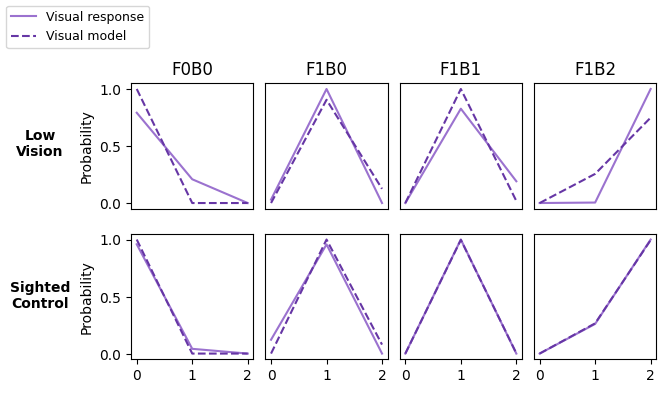

In [5]:
vis_col = '#6636a5'
resp_col = '#9b72cf'

subject_ids = ['LV020', 'SV215']
groups = ['Low Vision', 'Sighted Control']
location = 'raw'
conditions = ['F0B0', 'F1B0', 'F1B1', 'F1B2']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 4))

for row, (subject_id, group_label) in enumerate(zip(subject_ids, groups)):
    for col, condition in enumerate(conditions):
        ax = axes[row, col]

        ax.plot(
            all_props[subject_id][location][condition]['Visual response'],
            resp_col,
            label='Visual response'
        )
        ax.plot(
            all_props[subject_id][location][condition]['Visual model'],
            vis_col,
            linestyle='--',
            label='Visual model'
        )

        # aesthetics
        if col == 0:  # only show y ticks on first column
            ax.set_yticks([0, 0.5, 1])
            ax.set_ylabel('Probability')
        else:
            ax.set_yticks([])

        if row == 1:  # only show x ticks for bottom row
            ax.set_xticks([0, 1, 2])
        else:
            ax.set_xticks([])

        if row == 0:  # condition titles on top row
            ax.set_title(condition)

# Add group labels on the left for each row (figure-level text)
fig.text(0.02, 0.65, 'Low\nVision', va='center', ha='center', fontsize=10, fontweight='bold')
fig.text(0.02, 0.27, 'Sighted\nControl', va='center', ha='center', fontsize=10, fontweight='bold')

# plt.suptitle('Example Model Fits', fontsize=15, fontweight='bold')
fig.subplots_adjust(top=0.8, left=0.15, wspace=0.1)

# legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', fontsize=9)

plt.show()
